In [39]:
!nvidia-smi

Sat Jan  6 14:46:09 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-PCIE-40GB          On  | 00000000:27:00.0 Off |                    0 |
| N/A   34C    P0              37W / 250W |  36359MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [40]:
!kill 454306                  

In [1]:
import math
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import time as time
import numpy as np
from gradient_descent_the_ultimate_optimizer import gdtuo
from gradient_descent_the_ultimate_optimizer.gdtuo import Optimizable
import os
import matplotlib.pyplot as plt
import imageio
from IPython.display import Video, Image
from fourier_fit_relu import train_fourier_fit_relu as ffr
from fourier_fit_relu import plot_fourier_fit_relu as pffr

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

class MNIST_CNN(nn.Module):
    def __init__(self, fourier_act):
        super(MNIST_CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(16384, 128)  # Adjusted input dimensions
        self.fc2 = nn.Linear(128, 10)
        self.bn1 = nn.BatchNorm2d(3)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm1d(16384)

        self.fourier_act = fourier_act
        self.gather_stats = False

    def forward(self, x):
        x = self.bn1(x)
        x = self.conv1(x)

        x = self.fourier_act(x)

        x = self.bn2(x)
        x = self.conv2(x)

        x = self.fourier_act(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)

        x = self.bn3(x)
        x = self.fc1(x)

        x = F.gelu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

BATCH_SIZE = 256
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

dataset_train = torchvision.datasets.CIFAR10('./data_cifar', train=True, download=True, transform=torchvision.transforms.ToTensor())
dataset_test = torchvision.datasets.CIFAR10('./data_cifar', train=False, download=True, transform=torchvision.transforms.ToTensor())
dl_train = torch.utils.data.DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
dl_test = torch.utils.data.DataLoader(dataset_test, batch_size=256, shuffle=False)

cuda
Files already downloaded and verified
Files already downloaded and verified


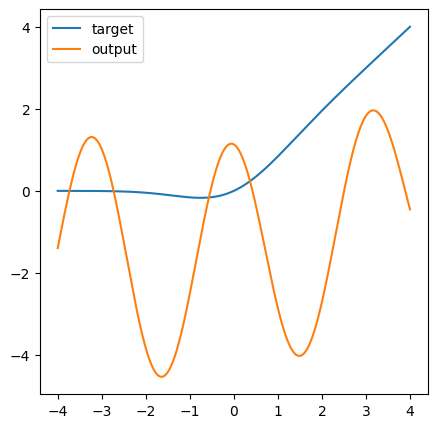

In [2]:
torch.cuda.empty_cache()
class FourierAct(Optimizable):
    def __init__(self, optimizer, parameters):

        self.rank = parameters['Acoeffs'].shape[0] -1
        self.optimizer = optimizer

        self.parameters = parameters
        self.all_params_with_gradients = [self.parameters['Acoeffs'], self.parameters['Bcoeffs'], self.parameters['period']]
        super().__init__(self.parameters, self.optimizer)

    def __call__(self, x):

        out = self.parameters['Acoeffs'][0] * torch.ones_like(x)

        for i in range (1, self.rank + 1):
            out += self.parameters['Acoeffs'][i] * torch.cos(2 * math.pi * i * x / self.parameters['period']) + self.parameters['Bcoeffs'][i - 1] * torch.sin(2 * math.pi * i * x / self.parameters['period'])

        return out
    
    def step(self):
        self.optimizer.step(self.parameters)

class Fourier_Act_torch(nn.Module):
    def __init__(self, rank = 5, parameters = None):
        super(Fourier_Act_torch, self).__init__()
        self.rank = rank
        self.Acoeffs = nn.Parameter(torch.randn(self.rank + 1))
        self.Bcoeffs = nn.Parameter(torch.randn(self.rank))
        self.period = nn.Parameter(torch.tensor(6*math.pi))
        if parameters is not None:
            self.Acoeffs = nn.Parameter(parameters['Acoeffs'])
            self.Bcoeffs = nn.Parameter(parameters['Bcoeffs'])
            self.period = nn.Parameter(parameters['period'])

        self.params = {'Acoeffs': self.Acoeffs, 'Bcoeffs': self.Bcoeffs, 'period': self.period}

    def forward(self, x):
        out = self.Acoeffs[0] * torch.ones_like(x)

        for i in range (1, self.rank + 1):
            out += self.Acoeffs[i] * torch.cos(2 * math.pi * i * x / self.period) + self.Bcoeffs[i - 1] * torch.sin(2 * math.pi * i * x / self.period)

        return out

mode = 'torch' # 'gdtuo' or 'torch'
fourier_act = Fourier_Act_torch(6)
parameters_init = {'Acoeffs': fourier_act.Acoeffs, 'Bcoeffs': fourier_act.Bcoeffs, 'period': fourier_act.period} 
fourier_act_init = Fourier_Act_torch(6, parameters_init)

if mode == 'gdtuo':
    fourier_act.initialize()

model = MNIST_CNN(fourier_act).to(DEVICE)

optim = torch.optim.Adam(model.parameters(), lr=0.003)
criterion = nn.CrossEntropyLoss()
pffr(fourier_act_init)

In [3]:
init_time = time.time()
EPOCHS = 10
A_list = [parameters_init['Acoeffs'].detach().cpu().numpy()]
B_list = [parameters_init['Bcoeffs'].detach().cpu().numpy()]
period_list = [parameters_init['period'].detach().cpu().numpy()]

for i in range(1, EPOCHS+1):
    running_acc = 0.0
    running_loss = 0.0
    for j, (features_, labels_) in enumerate(dl_train):

        if j % 50 == 0:
            if mode == 'torch':
                params = model.fourier_act.params
            else:
                params = fourier_act.parameters

            A_list.append(params['Acoeffs'].detach().cpu().numpy())
            B_list.append(params['Bcoeffs'].detach().cpu().numpy())
            period_list.append(params['period'].detach().cpu().numpy())

        if mode == 'gdtuo':
            fourier_act.begin()
            fourier_act.zero_grad()
        optim.zero_grad()

        features, labels = features_.to(DEVICE), labels_.to(DEVICE)
        pred = model.forward(features)
        loss = criterion(pred, labels)

        loss.backward(create_graph=True)

        optim.step()
        if mode == 'gdtuo':
            fourier_act.step()

        running_loss += loss.item() * features_.size(0)
        running_acc += (torch.argmax(pred, dim=1) == labels).sum().item()
    train_loss = running_loss / len(dl_train.dataset)
    train_acc = running_acc / len(dl_train.dataset)

    running_acc = 0.0
    with torch.no_grad():
        for j, (features_, labels_) in enumerate(dl_test):
            features, labels = features_.to(DEVICE), labels_.to(DEVICE)
            pred = model.forward(features)
            running_acc += (torch.argmax(pred, dim=1) == labels).sum().item()

    test_acc = running_acc / len(dl_test.dataset)
    print("EPOCH: {}, TRAIN LOSS: {}, ACC: {}".format(i, train_loss, train_acc))
    print("EPOCH: {}, TEST ACC: {}\n".format(i, test_acc))

print("Time taken: {}".format(time.time() - init_time))

/home/infres/egardes-21/.local/lib/python3.10/site-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
/home/infres/egardes-21/.local/lib/python3.10/site-packages/torch/autograd/__init__.py:200: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at ../torch/csrc/autog

EPOCH: 1, TRAIN LOSS: 1.8455631005477906, ACC: 0.3736
EPOCH: 1, TEST ACC: 0.4351

EPOCH: 2, TRAIN LOSS: 1.537383788986206, ACC: 0.44824
EPOCH: 2, TEST ACC: 0.4465

EPOCH: 3, TRAIN LOSS: 1.4842473398208618, ACC: 0.46928
EPOCH: 3, TEST ACC: 0.4638

EPOCH: 4, TRAIN LOSS: 1.4273862119293212, ACC: 0.49356
EPOCH: 4, TEST ACC: 0.4811

EPOCH: 5, TRAIN LOSS: 1.3700608841323854, ACC: 0.51572
EPOCH: 5, TEST ACC: 0.4977

EPOCH: 6, TRAIN LOSS: 1.3190011754226685, ACC: 0.53744
EPOCH: 6, TEST ACC: 0.5255

EPOCH: 7, TRAIN LOSS: 1.2553473001098632, ACC: 0.55772
EPOCH: 7, TEST ACC: 0.5264

EPOCH: 8, TRAIN LOSS: 1.213182589263916, ACC: 0.57578
EPOCH: 8, TEST ACC: 0.5341

EPOCH: 9, TRAIN LOSS: 1.1680666721725463, ACC: 0.59212
EPOCH: 9, TEST ACC: 0.5395

EPOCH: 10, TRAIN LOSS: 1.1169729308319092, ACC: 0.60926
EPOCH: 10, TEST ACC: 0.5587

Time taken: 198.42424702644348


In [4]:
for i in range(len(A_list)):
    x = np.linspace(-10, 10, 100)
    y_baseline = F.gelu(torch.tensor(x)).numpy()
    x = torch.tensor(x)
    if mode == 'gdtuo':
        cur_fourier_act = FourierAct(gdtuo.Adam(0.001), {'Acoeffs': torch.tensor(A_list[i]), 'Bcoeffs': torch.tensor(B_list[i]), 'period': torch.tensor(period_list[i])})
    else:
        cur_fourier_act = Fourier_Act_torch(5, {'Acoeffs': torch.tensor(A_list[i]), 'Bcoeffs': torch.tensor(B_list[i]), 'period': torch.tensor(period_list[i])})
    y = cur_fourier_act(x).detach().numpy()

    fig, ax = plt.subplots()
    ax.plot(x, y_baseline)
    ax.plot(x, y)

    # set small cross at 0.0
    ax.plot([0.0], [0.0], 'x', color='red')
    ax.set_title('fourier_act on all activations for CIFAR10 beats GeLU and ReLU')
    ax.set_xlabel('x')
    ax.set_ylabel('y')

    ax.legend(['baseline (gelu)', 'fourier_act'])
    ax.set_xlim([-10, 10])
    ax.set_ylim([-3, 10])
    ax.grid()

    os.makedirs('plots', exist_ok=True)
    plt.savefig('plots/{}.png'.format(i))
    plt.close()

video = './fourier_act.mp4'
imageio.mimsave(video, [imageio.imread('plots/{}.png'.format(i)) for i in range(len(A_list))], fps = 6)
#play it here
Video(video)

/tmp/ipykernel_2182076/906422389.py:31: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  imageio.mimsave(video, [imageio.imread('plots/{}.png'.format(i)) for i in range(len(A_list))], fps = 6)


: 